## Import packages

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

## Generate sample time series dataset 

Data
- x (features)
- y (labels)

In [2]:
x = torch.linspace(0,799,800)
y = torch.cos(x*2*3.1416/40)

Plot this sample data

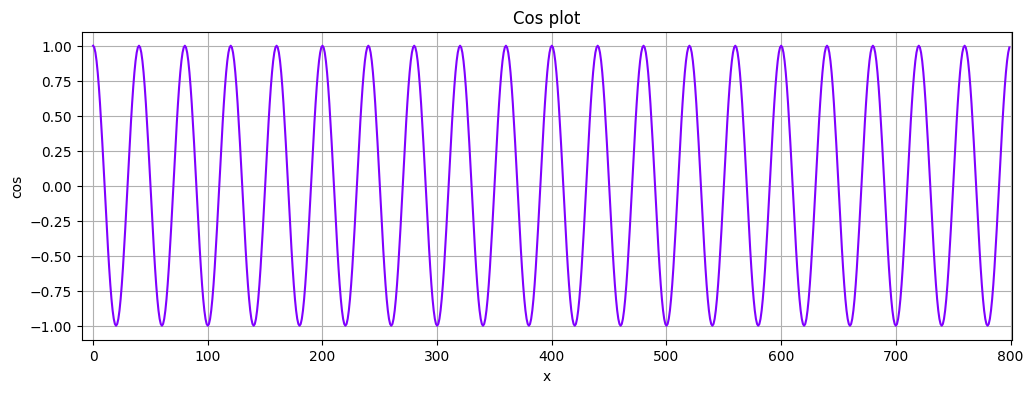

In [3]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("cos")
plt.title("Cos plot")
plt.plot(y.numpy(),color='#8000ff')
plt.show()

Now, let's split the data to train and test
- take first 760 samples to train a model
- last 40 samples to test the model 

In [4]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

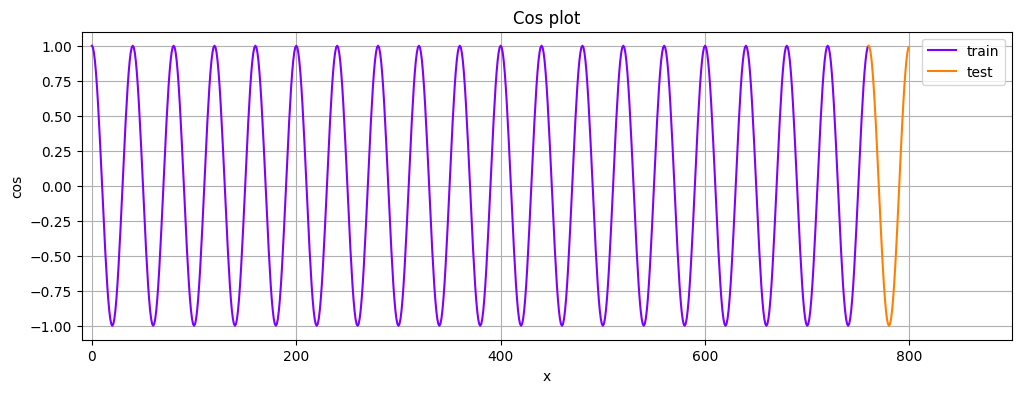

In [5]:
plt.figure(figsize=(12,4))
plt.xlim(-10,900)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("cos")
plt.title("Cos plot")
plt.plot(train_set.numpy(),color='#8000ff', label='train')
plt.plot(range(760,800),test_set.numpy(),color="#ff8000", label='test')
plt.legend()
plt.show()

In [6]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    
    return out

Data info
- The length of x = 800
- The length of train_set = 800 - 40 = 760
- The length of train_data = 760 - 40 - 720

In [7]:
window_size = 40
train_data = input_data(train_set, window_size)
len(train_data)

720

One training cycle (data)

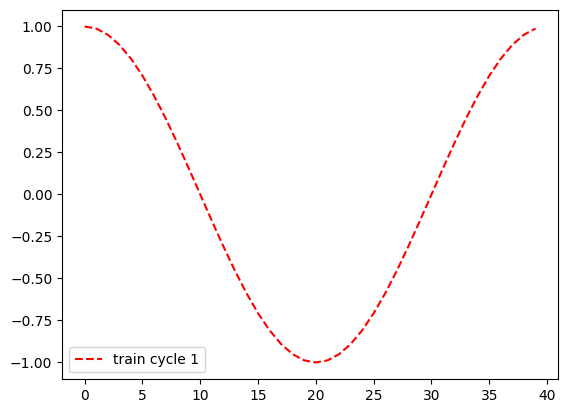

In [8]:
x_axis_1 = [i for i in range(40)]
plt.plot(x_axis_1, train_data[0][0].numpy(), color='red', linestyle='dashed', label='train cycle 1')
plt.legend()
plt.show()

## Create a LSTM model

Define
- input size
- output size
- hidden size

In [9]:
class LSTM(nn.Module):
    
    def __init__(self,input_size = 1, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [10]:
torch.manual_seed(42)
model = LSTM()

Define
- loss function (mean squared error)
- optimizer (SGD)
- learning rate (lr)

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [12]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

## Train LSTM model

Define
- epoch

Epoch 0 Loss: 0.04689374566078186
Performance on test range: 0.8652191162109375


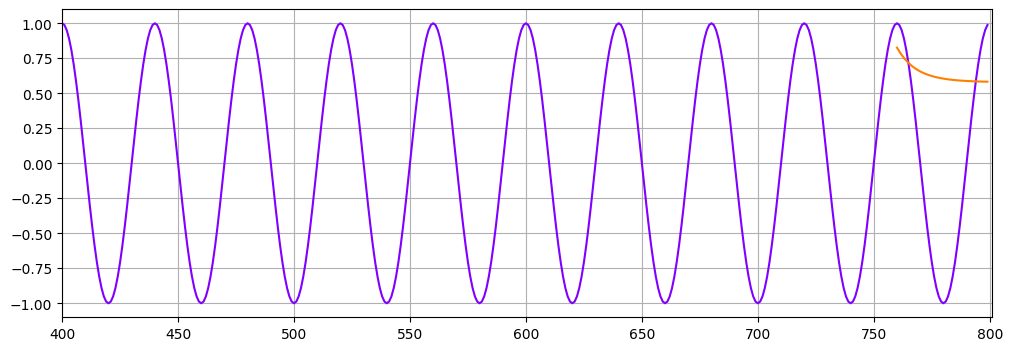

Epoch 1 Loss: 0.024934642016887665
Performance on test range: 0.9079908132553101


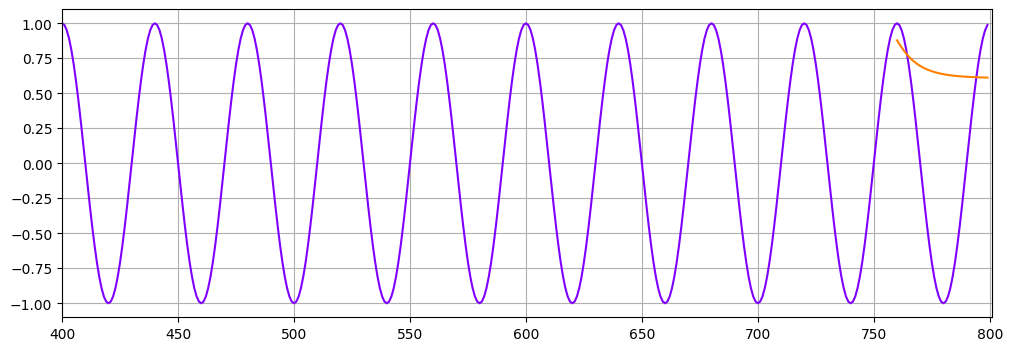

Epoch 2 Loss: 0.016036050394177437
Performance on test range: 0.8365851640701294


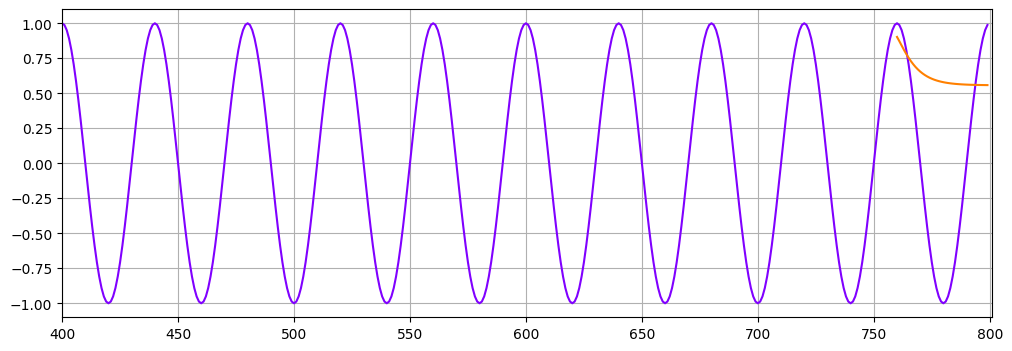

Epoch 3 Loss: 0.009752044454216957
Performance on test range: 0.614503026008606


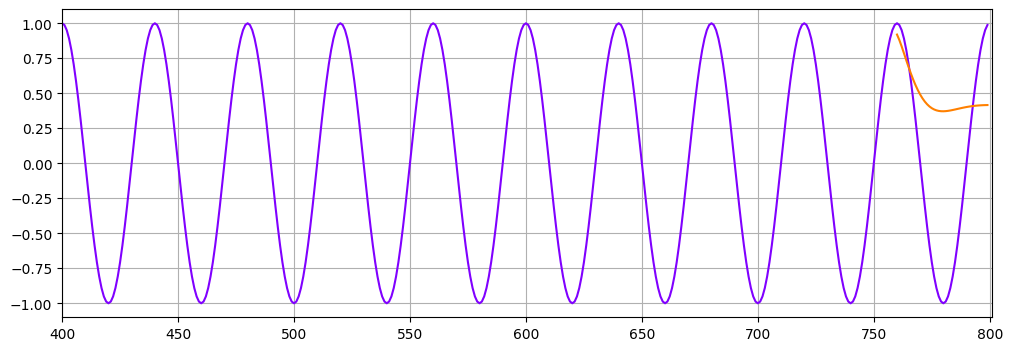

Epoch 4 Loss: 0.004144997801631689
Performance on test range: 0.21555760502815247


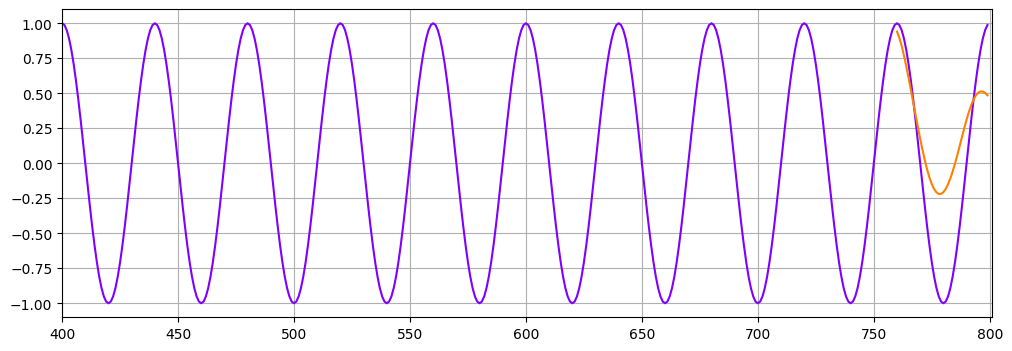

Epoch 5 Loss: 0.0017717838054522872
Performance on test range: 0.02121083438396454


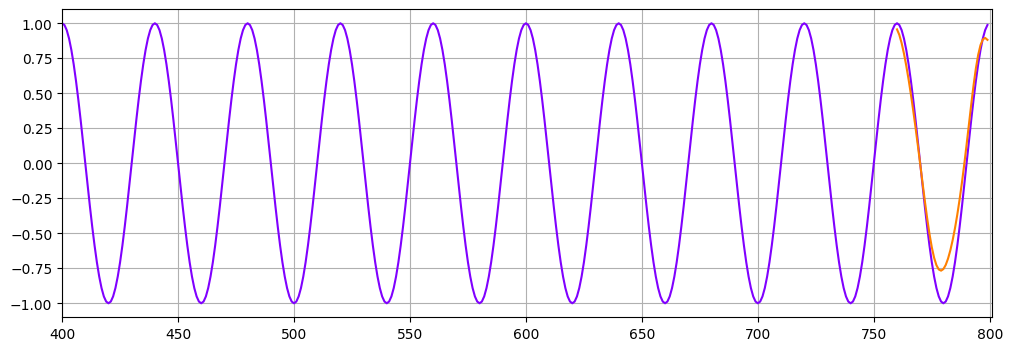

Epoch 6 Loss: 0.0012419202830642462
Performance on test range: 0.005937088746577501


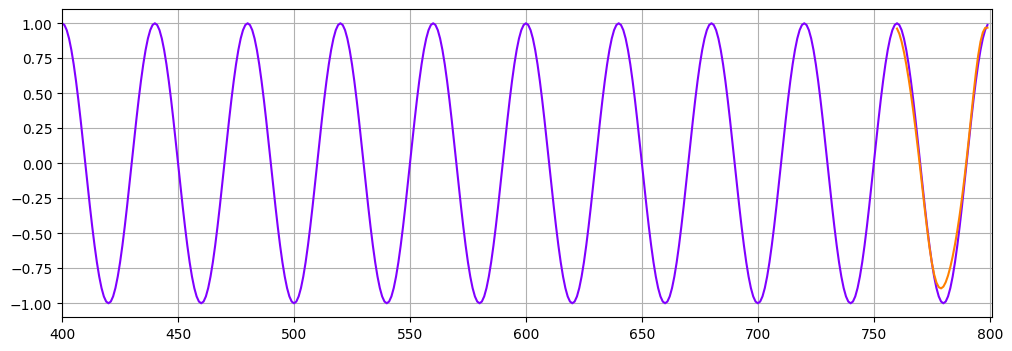

Epoch 7 Loss: 0.0010694499360397458
Performance on test range: 0.004344635643064976


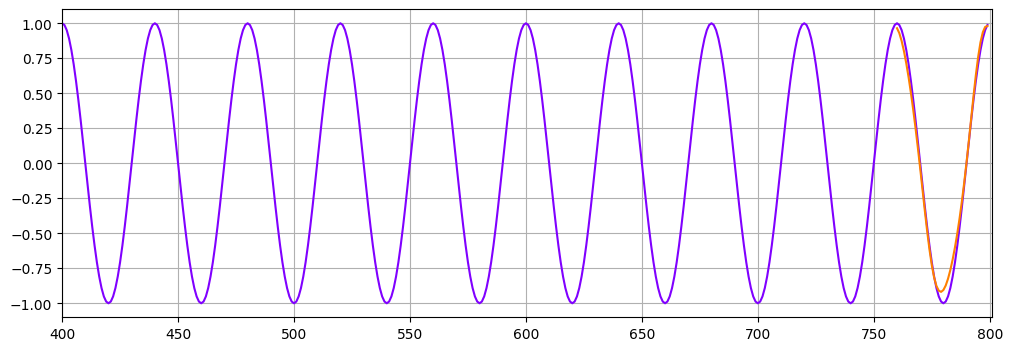

Epoch 8 Loss: 0.0009686511475592852
Performance on test range: 0.0037497072480618954


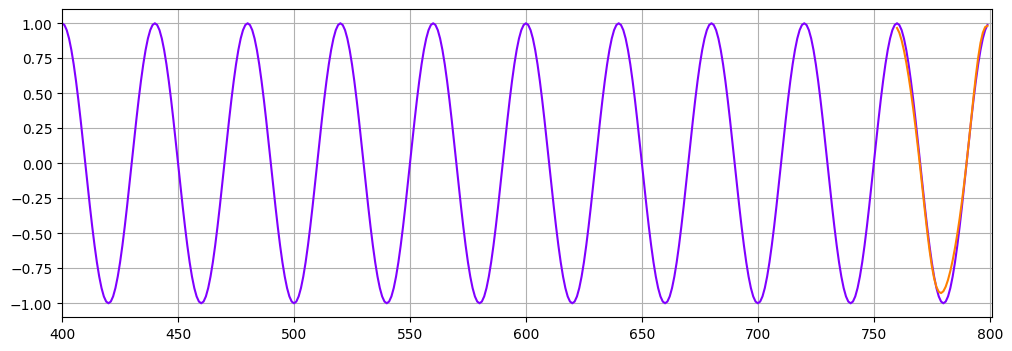

Epoch 9 Loss: 0.000893793476279825
Performance on test range: 0.0033159826416522264


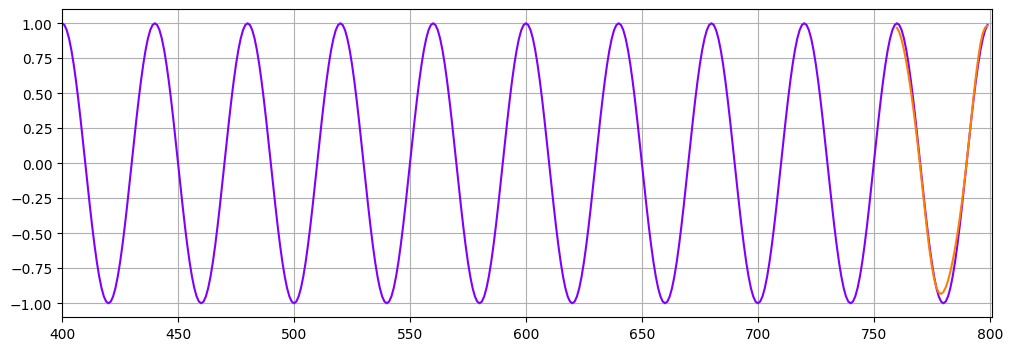

In [13]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = train_set[-window_size:].tolist()
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
        
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Performance on test range: {loss}")
    
    plt.figure(figsize=(12,4))
    plt.xlim(400,801)
    plt.grid(True)
    plt.plot(y.numpy(),color='#8000ff')
    plt.plot(range(760,800),preds[window_size:],color='#ff8000')
    plt.show()